<b>Exercise and Non-Exercise Predictors of Heart Disease</b>

Heart disease (HD) has many symptoms, thus, diagnosis is difficult, and it is critical to minimize testing (Bösner et al., 2010), while “[identifying] serious cardiac disease reliably” (Bösner et al., 2010). The question we are asking is: Can exercise-related parameters can more accurately diagnose HD than non-exercise-related predictors? We will create one model classifying non-exercise factors including age, resting electrocardiogram, and resting blood pressure, and another for exercise-related factors including ST depression during exercise, angina during exercise, and slope (Detrano, n.d.). We used the “Heart Disease Data Set” (Detrano, n.d.), specifically the processed.cleveland.data, including 14 variables, with the diagnosis denoted from 0-4 (Detrano, n.d.).

In [2]:
#Source for the code:

#Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
#Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [3]:
# Installation of the required libraries to conduct our data analysis. Setting of the seed to ensure our analysis is reproducible (Detrano, n.d.).
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(9999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [4]:
# Reading in the data from our online source (Detrano, n.d.) using a read_csv function. 
cleveland_data <- read_csv("data/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<b>WRANGLING THE DATA:</b>

In [5]:
# Set the dataset's column names to the variable descriptions found in (Detrano, n.d.).
colnames(cleveland_data) <- c("age", "sex", "cp", "resting_blood_pressure", "chol", "fbs", "resting_electrocardio", "thalach", "exercise_angina", "exercise_st", "exercise_slope", "ca", "thal", "result")

In [6]:
# Mutate the result column into a factor, so it can be used to color and fill the graphs.
cleveland_data <- mutate(cleveland_data, result = as_factor(result))

# Wrangling the data by creating the desired datasets.
# First Dataset: data collected from patients in the non-exercise state.
cleveland_data_resting <- select(cleveland_data, age, resting_blood_pressure, resting_electrocardio, result) 

# Second Dataset: data collected from patients after exercise.
cleveland_data_exercise <- select(cleveland_data, exercise_angina, exercise_st, exercise_slope, result)

In [7]:
# We used map_df to calculate the average value of each column, which helps us know the general range of values for each column.
# This also helps us by letting us know that we need to scale the data.
cleveland_data_resting_mean <- cleveland_data_resting |>
    select(age:resting_electrocardio) |>
    map_df(mean)
cleveland_data_resting_mean

age,resting_blood_pressure,resting_electrocardio
<dbl>,<dbl>,<dbl>
54.43894,131.6898,0.990099


<b>Table 1:</b> Means of the non-exercise predictor variables. 

In [8]:
# We used map_df to calculate the average value of each column, which helps us know the general range of values for each column.
# This also helps us by letting us know that we need to scale the data.

cleveland_data_exercise_mean <- cleveland_data_exercise |>
    select(exercise_angina:exercise_slope) |>
    map_df(mean)
cleveland_data_exercise_mean

exercise_angina,exercise_st,exercise_slope
<dbl>,<dbl>,<dbl>
0.3267327,1.039604,1.60066


<b>Table 2:</b> Means of the exercise predictor variables. 

We wrangled the data to create our datasets from the processed.cleveland.data (Detrano, n.d.). Our first dataset includes non-exercise parameters including age, as this contributes to HD diagnosis, with older ages being risk factors (Bösner et al., 2010). Blood sugar after fasting is included as in many experiments its correlation to HD has been identified (Shin et al., 2019). Finally, we used resting blood pressure as it constitutes “one of the most important risk factors for cardiovascular disease” (Wu et al., 2015). Our second dataset includes exercise-related predictors. ST depression during exercise is used as it is related to HD outcome, thus having medical value (Lanza et al., 2004). Angina during exercise is used as exercise stresses the heart, exposing this symptom (Harvard Health Publishing, 2021). Finally, the slope is used to study the involvement of exercise testing for HD predictions, correlating to the extent of illness (Finkelhor et al., 1986). Both contain the result variable, indicating the categorical diagnosis (Detrano, n.d.). 

To preliminarily visualize our data, we looked at the means of each variable (see Tables 1 and 2) to understand their ranges. We see that the means of each variable are not comparable within a single dataset, which tells us that we will be required to scale them for modeling.

<b>SPLITTING THE DATA INTO TRAINING AND TESTING:</b>

We will perform a $K$-nearest neighbors classification, using tidymodels, thus we split 75% of the data into training datasets, and the remaining 25% into testing datasets to utilize sufficient data to build accurate models. 

In [9]:
# Splitting the datasets into training and testing data using 75% of the data in the training set.
set.seed(9999)

initial_split <- initial_split(cleveland_data_resting, prop = 0.75, strata = result)  
resting_train <- training(initial_split)   
resting_test <- testing(initial_split)

initial_split <- initial_split(cleveland_data_exercise, prop = 0.75, strata = result)  
exercise_train <- training(initial_split)   
exercise_test <- testing(initial_split)

<b>VISUALIZING THE DATA:</b>

Our preliminary visualization is in histograms as our predictors are either binary or adopt a range of values. The predictors’ values are on the x-axis and diagnoses, from 0 (no HD) to 4 (severe HD) are on the y-axis. 

<b>GROUP 1 GRAPHS:</b>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



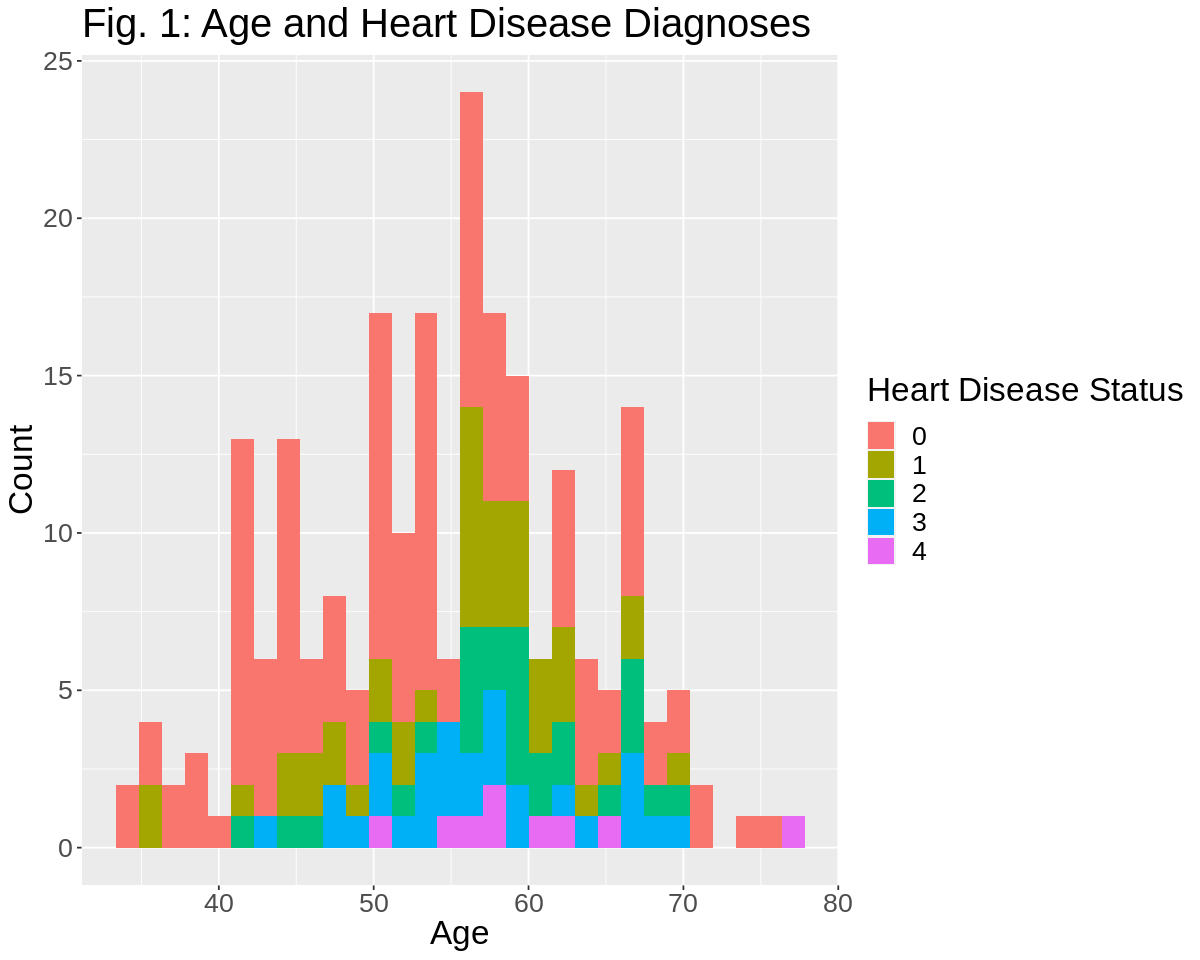

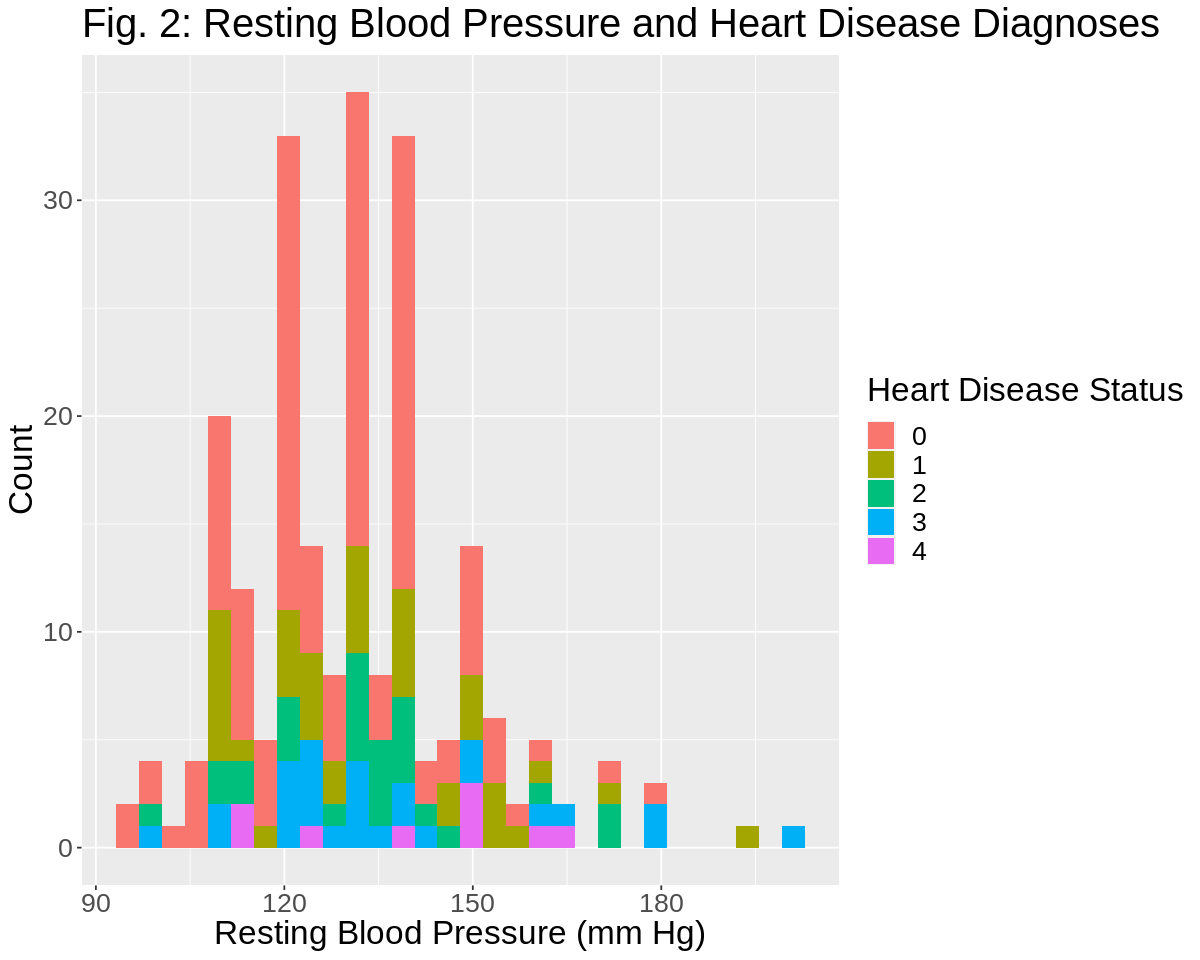

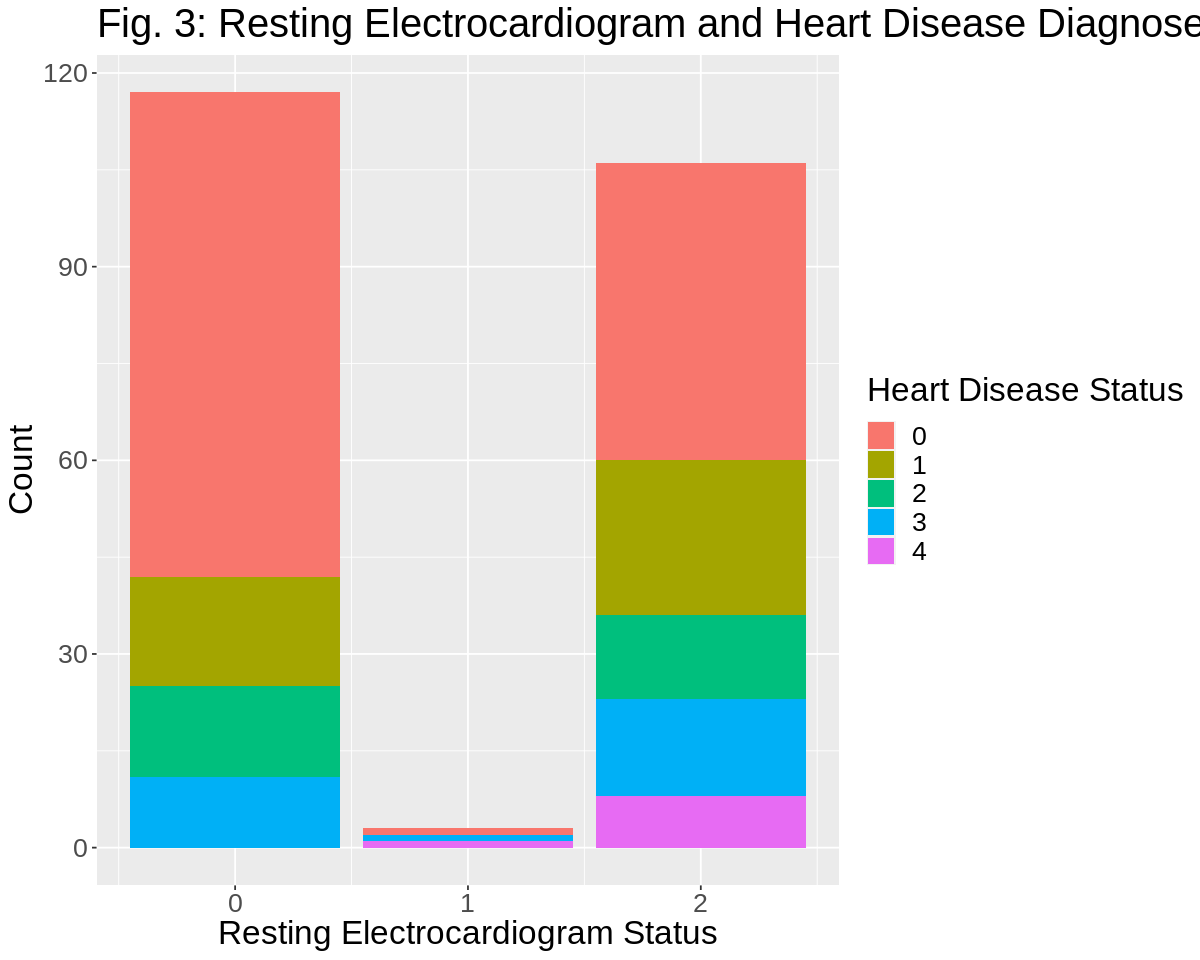

In [10]:
#Creating the plots to visualize the predictors from the first dataset in relation to the severity of heart disease. 
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

resting_age_plot <- ggplot(resting_train, aes(x = age)) +
    ggtitle("Fig. 1: Age and Heart Disease Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Age") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
resting_age_plot

resting_bps_plot <- ggplot(resting_train, aes(x = resting_blood_pressure)) +
    ggtitle("Fig. 2: Resting Blood Pressure and Heart Disease Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Resting Blood Pressure (mm Hg)") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
resting_bps_plot

resting_electro_plot <- ggplot(resting_train, aes(x = resting_electrocardio)) +
    ggtitle("Fig. 3: Resting Electrocardiogram and Heart Disease Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Resting Electrocardiogram Status") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
resting_electro_plot

These histograms are important to show us the distribution of our predictors, and how heart rate diagnosis is associated with each value the predictor can hold. In Figure 1, ages are between 5 and 75, with most data being concentrated around ages 50 to 65. This tells us that within our datasets there will be more data for people aged 50-65 as we have more of these data, so this will have the most effect on our model. In Figure 2, we see there is a range of resting blood pressure ~95 mmHg to ~205 mmHg, with most data concentrated near 105 mmHg to 150 mmHg. We also see that a large portion of these data are associated with a diagnosis as not having heart disease (red portion of the bar). Finally, looking at the resting electrocardiographic data in Figure 3, we see that most observations are assigned as either 0 or 2, very few are at 1. When the resting electrocardiogram is assigned 0, more than half the observations are diagnosed as not having HD. However, when it is assigned 2, we see that each diagnosis occurs, with some observations having no HD (0), and some with very severe disease (4). These graphs help us to picture the association between the values that our predictors can hold and the HD diagnosis. Looking at the range of each of the predictors graphically also reemphasizes the importance of scaling our data when modeling, as the scale differs significantly with each predictor.  

<b>GROUP 2 GRAPHS:</b>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



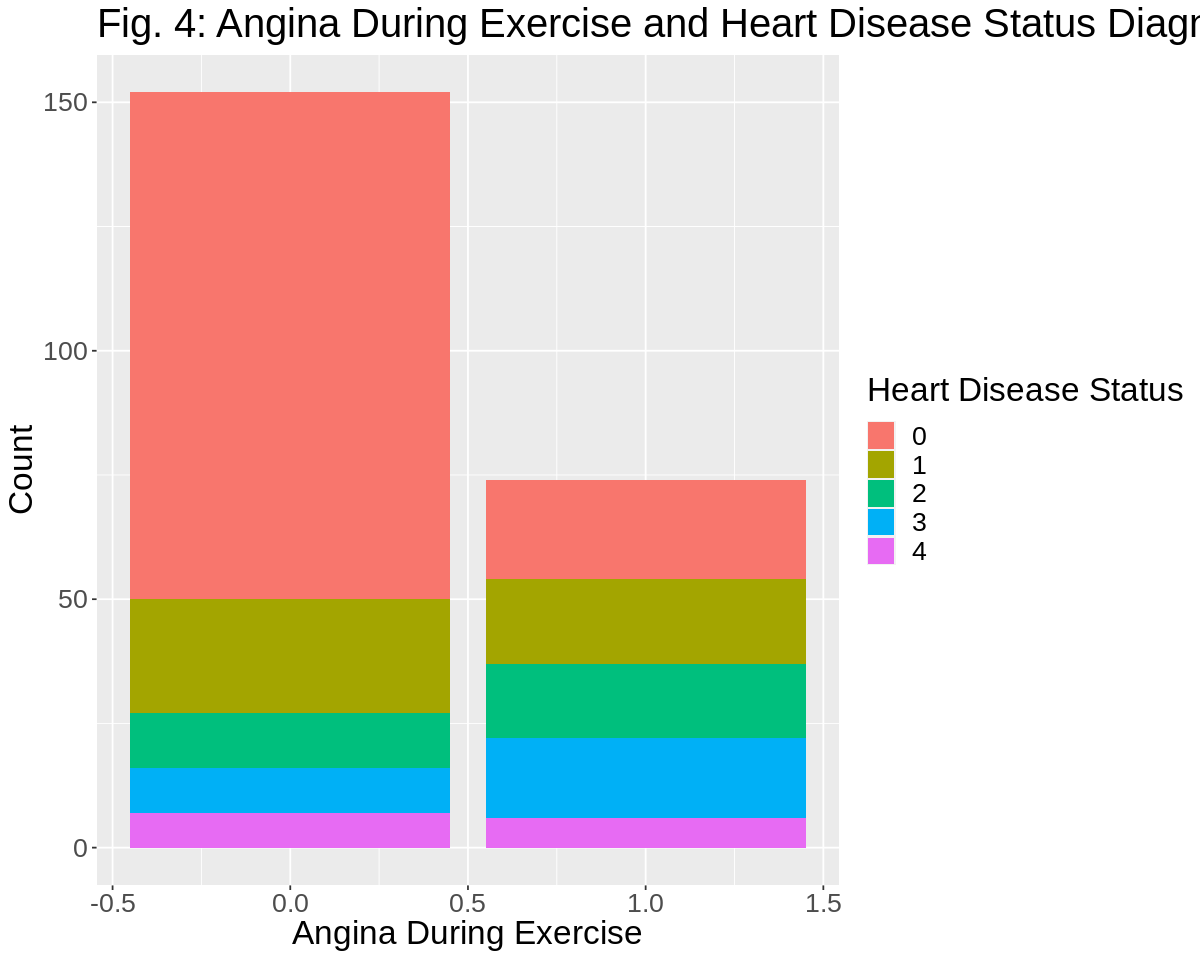

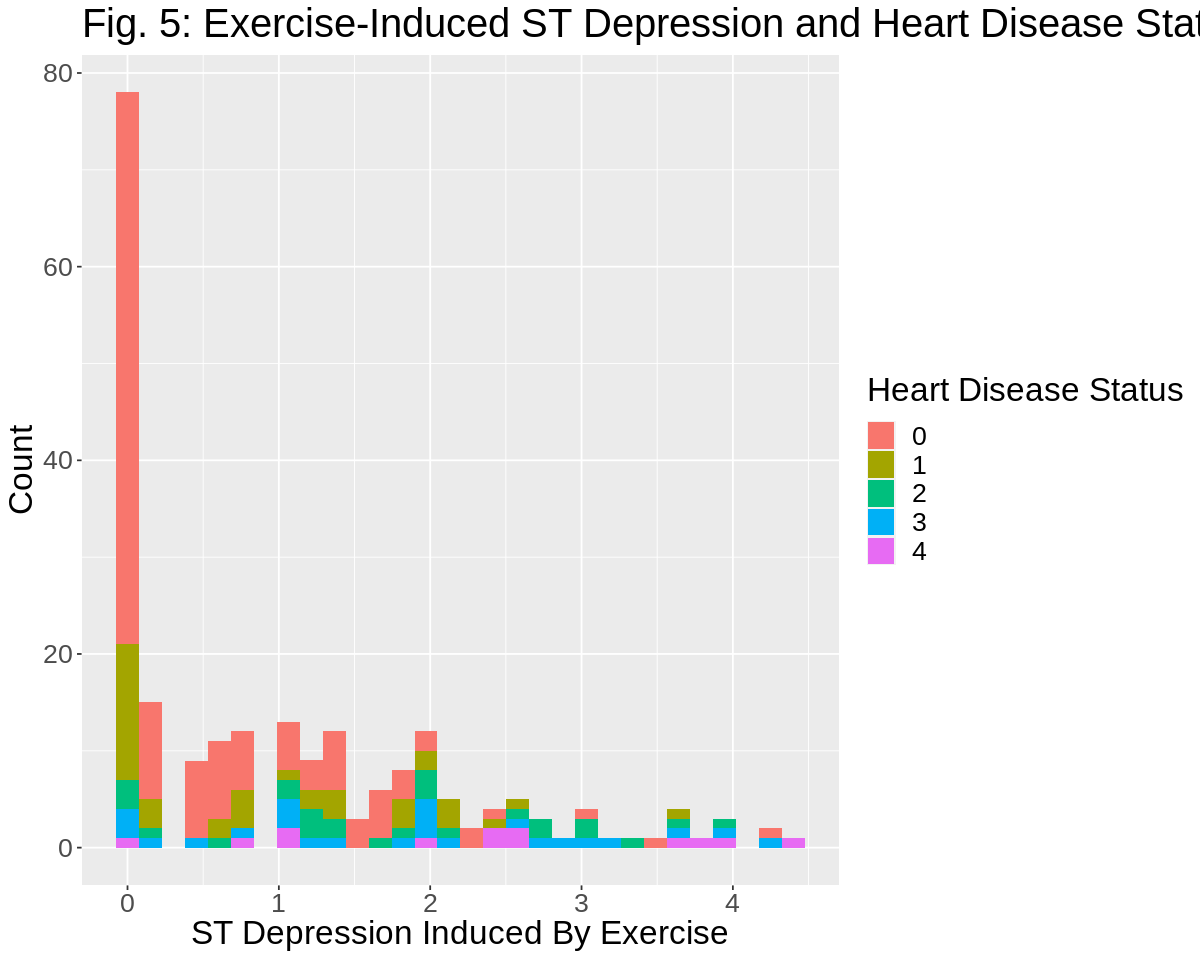

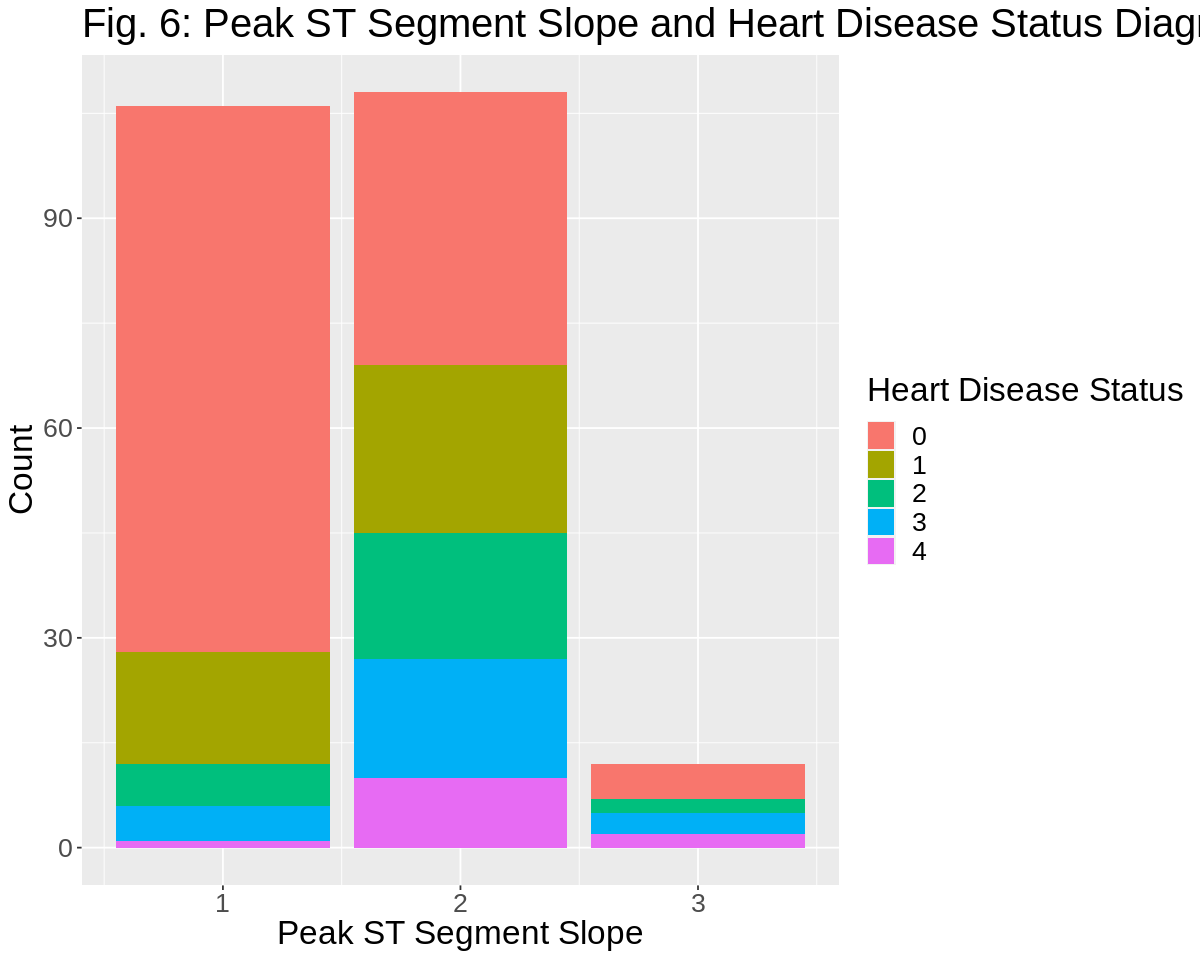

In [11]:
#Creating the plots to visualize the predictors in the second data set in relation to the severity of heart disease.
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

exercise_angina <- ggplot(exercise_train, aes(x = exercise_angina)) +
    ggtitle("Fig. 4: Angina During Exercise and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Angina During Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
exercise_angina

exercise_st_plot <- ggplot(exercise_train, aes(x = exercise_st)) +

    ggtitle("Fig. 5: Exercise-Induced ST Depression and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("ST Depression Induced By Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
exercise_st_plot

exercise_slope_plot <- ggplot(exercise_train, aes(x = exercise_slope)) +
    ggtitle("Fig. 6: Peak ST Segment Slope and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Peak ST Segment Slope") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
exercise_slope_plot

These histograms serve to show us the association between our exercise predictors and the diagnosis of HD. In Figure 4, which relates angina during exercise to HD diagnosis, we see that this is a binary predictor, associated with values 0 or 1. We see that there are more observations associated with a value of 0 than with a value of 1. With that being said, a large portion of those with angina of 0 have a HD diagnosis of 0 as well, indicating no HD. With an angina of 1, we see that each diagnosis is roughly evenly represented. In Figure 5, we are looking at the distribution of the ST depression induced by exercise and we see that it holds values between 0 and 4.5. The largest proportion is at 0, and the majority of them are not diagnosed as having HD (diagnosis of 0). With increasing ST depression, there is less HD diagnosis of 0. Finally, in Figure 6, we are looking at the peak ST segment slope. This can adopt values of 1, 2, or 3. We see that most observations are at values of 1 or 2, and that the number of individuals with no diagnosis of HD (0) decreases as the peak ST segment slope increases. These graphs help us understand the range of our data, and make some preliminary predictions about which predictor values are most associated with HD diagnosis. Again, these show the range of our predictors and reemphasize the importance of scaling them before modeling. 

To conduct our analysis, we will  scale and center our data to create a model. This requires cross-validation to determine each dataset’s optimal $K$, then our model will be fit to the testing data to classify the patients by diagnosis. Our goal is to determine the most accurate model, evaluating the metrics and confusion matrix for each. To visualize our results we will create a bar plot denoting the number of correct/incorrect predictions in the testing dataset for each model to determine their accuracy.  

In conclusion, we are determining whether exercise or non-exercise predictors are more effective at diagnosing HD. We expect that having patients exercise before diagnosis will be a more effective strategy than without analyzing physical effort. This can impact diagnostic accuracy, by expanding our range of diagnostic tests. While it could be more time-consuming than traditional methods, and unrealistic in extreme situations, it could lead to questioning how we can apply the most appropriate diagnostic method in all patient circumstances. 

<b>NON-EXERCISE PREDICTORS MODELLING:</b>

The first model that we are producing attempts to predict an individual's HD diagnosis in relation to predictor variables that do not depend on physical exercise to analyze. These include age, resting blood pressure, and resting electrocardiographic data. This model and its accuracy when evaluated on the testing data will allow us to determine whether a diagnostic paradigm for HD including these three variables will be sufficient to diagnosis and individual's status. 

We need to determine the number of each result in our training data to determine if the classes are balanced. 

In [ ]:
number_of_each_result <- resting_train |>
    group_by(result) |>
    summarize(count = n())
number_of_each_result

We see that the classes are not balanced in the training data, there are significantly more diagnoses at 0 than in the other diagnostic classes, thus we will have to balance the classes in our model.

The first step to preparing this model is making the recipe. This recipe serves to indicate which categorical we want to classify with respect to, as well as which variables this classification depends on, called predictor variables. This recipe will scales and centers the data, as well as balances it so that we rectify the scaling and balacing issues that we saw in our preliminary analysis. We saw that the range of the all the predictors was not the same in that initial analysis which would pose problems with classification as the ones with a wider range would have a larger effect on our model, and thus predictions than those with a narrower range. This scaling and centering step ensures that all predictors are on the same range, thus contributing equally to the model. Also, we saw that there were a lot more diagnoses of 0 which means our model will be more influenced by those so we need to balance our recipe. 

In [12]:
# Creating a recipe for the classification using the resting data. 
set.seed(9999)

resting_recipe <- recipe(result ~ age + resting_blood_pressure + resting_electrocardio, data = resting_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

After creating the recipe, we now need to produce a model that indicates the type of analysis we are conducting, in this case a classification analysis. We specify that neighbours = tune() because we have not selected a K value to use yet. A key part of producing a good classification model is that we select the right value for the neighbours parameter, thus we need to tune the model and find the K that yields the most accurate model.  

In [13]:
# Creating a model for the classification that we can tune to find the best K. 
set.seed(9999)

resting_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

As part of tuning the model, we need to do a cross-validation analysis. This involves using the training dataset that we created and splitting this into training sets and a validation set. This function trains the model on all the training set, then determines its accuracy on the validation set. With an average of the accuracy across all the validation sets, we can determine the accuracy of the model. By creating a tibble of K values to try, we can do this cross-validation across all these K values to determine the most accurate K to incorporate into our model. These two elements are combined into the workflow to determine the K accuracy with the collect_metrics function. 

In [14]:
set.seed(9999)

# Creating a cross validation set. 

resting_vfold <- vfold_cv(resting_train, v = 10, strata = result)

# Creating a subset of K values to try. 

k_to_try <- tibble(neighbors = seq(from = 1, to = 60, by = 2))
                   
# Creating a workflow to determine the best K. 

resting_model_workflow <- workflow() |>
                            add_recipe(resting_recipe) |>
                            add_model(resting_model_tune) |>
                            tune_grid(resamples = resting_vfold, grid = k_to_try) |>
                            collect_metrics()

! Fold03: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.

! Fold05: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.

! Fold09: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



Now that we have completed the cross-validation we have to use its data to determine the best K. By filtering the data frame for the accuracy metric and plotting the accuracy across a range of K values, we can determine the most accurate K, and thus the one to use in our model. We are looking for a K with a high accuracy, and with the K values beside it also having a high accuracy, which accounts for any error that occurs in our algorithm. 

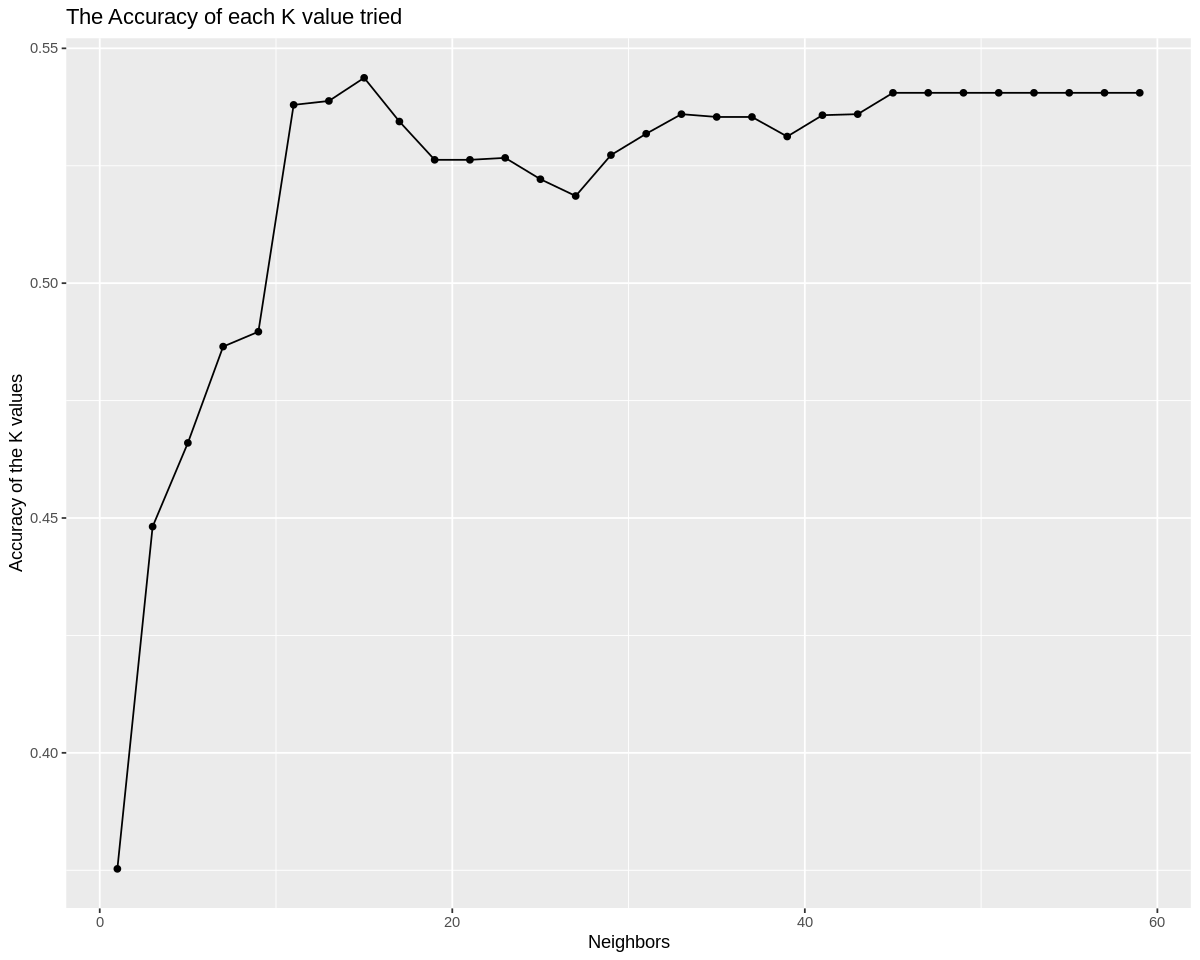

In [15]:
# Filtering the accuracy of each K from the metrics.

accuracy_of_k <- resting_model_workflow |>
                    filter(.metric == "accuracy")

# Making a plot of the accuracy to use to determine the best K for this analysis. 

accuracy_plot <- accuracy_of_k |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("The Accuracy of each K value tried")
accuracy_plot

From the above plot, we will choose K=17 to build this model. This is because this K generates the highest accuracy, while still having the K values adjacent to it being relatively accurate as well. 

Now that we have determined the best K for our modeling with these data, we will create a new model that uses this most accurate K. Therefore, within our model, instead of indicating neighbours = tune(), we will use neighbours = 17. This can then be added to a workflow with the recipe we created above (resting_recipe) to the training data (resting_train). We only fit the model to the training data because this is the data that we use to train our model with, therefore, it is important for the model to not come into contact with the testing data before it makes predictions on it, so that training the model has no effect on the accuracy of those predictions. Finally, we can predict the labels for the testing data (resting_test), using the fitted model to the training data (best_resting_fit). 

In [16]:
set.seed(9999)

# Creating a new model which includes the K to generate the best fit. 

best_resting_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Creating a workflow to fit the best model to our training data to train the model. 

best_resting_fit <- workflow() |>
                        add_recipe(resting_recipe) |>
                        add_model(best_resting_model) |>
                        fit(data = resting_train)

# Fitting the model to our testing data to make the predictions. 

resting_predictions <- best_resting_fit |>
                        predict(resting_test) |>
                        bind_cols(resting_test)

Now that we successfully predicted the testing set's labels, we have to determine how good our model actually was at making those predictions. Thus, we look at the metrics, indicating the model's accuracy, and the confusion matrix, indicating the number of successful as compared to unsuccessful predictions completed by our model, with respect to each value of the diagnosis (result variable). 

In [17]:
set.seed(9999)

# Looking at the metrics and confusion matrix for this model to determine its accuracy.

resting_metrics <- resting_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |>
                    select(.estimate) |>
                    pull()
resting_metrics

resting_conf_mat <- resting_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)
resting_conf_mat

[1] 0.4805195

          Truth
Prediction  0  1  2  3  4
         0 36 13  7  6  3
         1  6  1  2  2  1
         2  0  0  0  0  0
         3  0  0  0  0  0
         4  0  0  0  0  0

Looking at these data, we see that the accuracy of this model which considers only the resting data is ~0.48. This means that less than 50% of the time our model predicts the diagnosis correctly. As well, with the confusion matrix we see that none of the result values of 2, 3, 4 were correctly predicted, however, there were some correct predictions of 1, 2. 

<b>EXERCISE PREDICTORS MODELLING</b>

In [18]:
# Creating a recipe for the classification using the resting data. 
set.seed(9999)

exercise_recipe <- recipe(result ~ exercise_angina + exercise_st + exercise_slope, data = exercise_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

In [19]:
# Creating a model for the classification that we can tune to find the best K. 
set.seed(9999)

exercise_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

In [20]:
set.seed(9999)

# Creating a cross validation set. 

exercise_vfold <- vfold_cv(exercise_train, v = 10, strata = result)

# Creating a subset of K values to try. 

k_to_try <- tibble(neighbors = seq(from = 1, to = 60, by = 2))
                   
# Creating a workflow to determine the best K. 

exercise_model_workflow <- workflow() |>
                            add_recipe(exercise_recipe) |>
                            add_model(exercise_model_tune) |>
                            tune_grid(resamples = exercise_vfold, grid = k_to_try) |>
                            collect_metrics()

! Fold03: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.

! Fold06: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



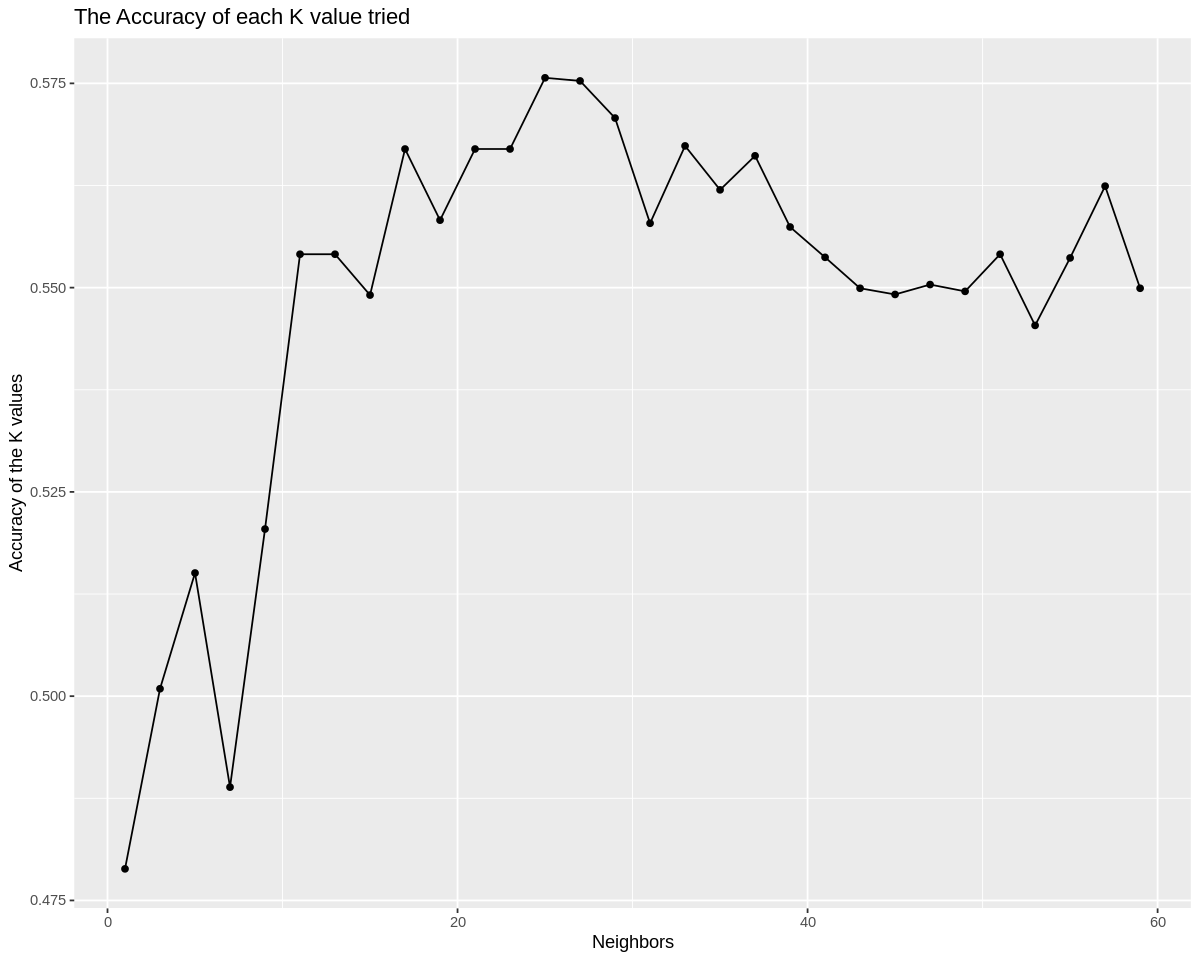

In [21]:
accuracy_of_k_exercise <- exercise_model_workflow |>
                    filter(.metric == "accuracy")

# Making a plot of the accuracy to use to determine the best K for this analysis. 

accuracy_plot_exercise <- accuracy_of_k_exercise |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("The Accuracy of each K value tried")
accuracy_plot_exercise

From the above plot, we will choose K=25 to build this model. This is because this K generates the highest accuracy, while still having the K values adjacent to it being relatively accurate as well.

In [23]:
set.seed(9999)

# Creating a new model which includes the K to generate the best fit. 

best_exercise_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Creating a workflow to fit the best model to our training data to train the model. 

best_exercise_fit <- workflow() |>
                        add_recipe(exercise_recipe) |>
                        add_model(best_exercise_model) |>
                        fit(data = exercise_train)

# Fitting the model to our testing data to make the predictions. 

exercise_predictions <- best_exercise_fit |>
                        predict(exercise_test) |>
                        bind_cols(exercise_test)

In [24]:
set.seed(9999)

# Looking at the metrics and confusion matrix for this model to determine its accuracy.

exercise_metrics <- exercise_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |>
                    select(.estimate) |>
                    pull()
exercise_metrics

exercise_conf_mat <- exercise_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)
exercise_conf_mat

[1] 0.6103896

          Truth
Prediction  0  1  2  3  4
         0 42 10  3  2  0
         1  0  3  4  5  0
         2  0  0  0  0  0
         3  0  2  3  2  0
         4  0  0  0  1  0

Word count: 499 words

<b>References:</b>

Bösner, S., Becker, A., Hani, M.A., Keller, H., Sönnichsen, A.C., Haasenritter, J., Karatolios, K., Schaefer, J.R., Baum, E., and Donner-Banzhoff, N. (2010). Accuracy of Symptoms and Signs for Coronary Heart Disease Assessed in Primary Care. British Journal of General Practice, 60(575), 246-257. 10.3399/bjgp10X502137

Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Finkelhor, R.S., Newhouse, K.E., Vrobel, T.R., Miron, S.D., and Bahler, R.C. (1986). The ST Segment/Heart Rate Slope as a Predictor of Coronary Artery Disease: Comparison with Quantitative Thallium Imaging and Conventional ST Segment Criteria. American Heart Journal. 112(2). 296-304. https://doi.org/10.1016/0002-8703(86)90265-6

Harvard Health Publishing. (2021, September 21). Angina: Symptoms, diagnosis and treatments. Harvard Medical School. https://www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-andtreatments#:~:text=September%2021%2C%202021,by%20cholesterol%2Dclogged%20coronary%20arteries.

Lanza, G.A., Mustilli, M., Sestito, A., Infusino, F., Sgueglia, G.A., and Crea, F. (2004). 
Diagnostic and Prognostic Value of ST Segment Depression Limited to the Recovery Phase of Exercise Stress Test. Heart. 90(12). 1417-1421. 10.1136/hrt.2003.031260

Shin, J., Ham, D., Shin, S., Choi, S.K., Paik, H-Y., and Joung, H. (2019). Effects of 
Lifestyle-Related Factors on Ischemic Heart Disease According to Body Mass Index and Fasting Blood Glucose Levels in Korean Adults. PLoS ONE, 14(5), https://doi.org/10.1371/journal.pone.0216534

Wu, C-Y., Hu, H-Y., Chou, Y-J., Huang, N., Chou, Y-C., Li, C-P. (2015). High Blood Pressure 
and All-Cause and Cardiovascular Disease Mortalities in Community-Dwelling Older Adults. Medicine (Baltimore). 94(47). 10.1097/MD.0000000000002160
